In [1]:
from teleconnections import Teleconnection

In [2]:
tc_ERA = Teleconnection(model='ERA5', exp='era5', source='monthly', telecname='NAO', loglevel='INFO', startdate='1990-01-01', enddate='2020-12-31', regrid='r100', savefig=False, savefile=False)

2024-04-08 13:38:11 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-04-08 13:38:11 :: Teleconnection :: INFO     -> Namelist loaded
2024-04-08 13:38:11 :: Reader :: WARNING  -> DATA_PATH parameter is required but is missing, setting to default /pfs/lustrep3/projappl/project_465000454/data/AQUA/datasets
2024-04-08 13:38:12 :: Reader :: INFO     -> Fix names in metadata is ERA5-destine-v1
2024-04-08 13:38:12 :: Reader :: INFO     -> Fix names ERA5-destine-v1 found in fixes files
2024-04-08 13:38:13 :: Reader :: INFO     -> Grid metadata is era5-r025
2024-04-08 13:38:18 :: Teleconnection :: INFO     -> Reader initialized


In [3]:
tc_ERA.evaluate_index()

2024-04-08 13:38:18 :: Teleconnection :: INFO     -> No retrieve has been performed, trying to retrieve
2024-04-08 13:38:18 :: Reader :: INFO     -> Retrieving variables: ['msl']
2024-04-08 13:38:18 :: Reader :: INFO     -> Retrieving variables: ['msl']
2024-04-08 13:38:20 :: Reader :: INFO     -> Variables to be fixed: {'msl': {'grib': True, 'source': 'MSL'}}
2024-04-08 13:38:20 :: Reader :: INFO     -> msl: converting units Pa --> Pa
2024-04-08 13:38:20 :: Reader :: INFO     -> coordinates adjusted to cf by AQUA fixer
2024-04-08 13:38:20 :: Teleconnection :: INFO     -> Data retrieved
2024-04-08 13:38:20 :: Teleconnection :: INFO     -> Data regridded to r100
2024-04-08 13:38:54 :: Teleconnection :: INFO     -> Index evaluated


In [4]:
tc_test = Teleconnection(model='IFS-NEMO', exp='ssp370', source='lra-r100-monthly', telecname='NAO', loglevel='INFO', savefig=False, savefile=False)
tc_test.evaluate_index()

2024-04-08 13:38:54 :: Teleconnection :: INFO     -> No regrid will be performed, be sure that the data is already at low resolution
2024-04-08 13:38:54 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-04-08 13:38:54 :: Teleconnection :: INFO     -> Namelist loaded
2024-04-08 13:38:54 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-04-08 13:38:54 :: Teleconnection :: INFO     -> Namelist loaded
2024-04-08 13:38:54 :: Reader :: WARNING  -> DATA_PATH parameter is required but is missing, setting to default /pfs/lustrep3/projappl/project_465000454/data/AQUA/datasets
2024-04-08 13:38:54 :: Reader :: INFO     -> No specific fix found, will call the default fix IFS-NEMO-default
2024-04-08 13:38:54 :: Reader :: WARNING  -> The requested default fixer name IFS-NEMO-default does not exist in fixes files
2024-04-08 13:38:54 :

In [5]:
index_ERA = tc_ERA.index
index_test = tc_test.index

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
from teleconnections import bootstrap_teleconnections

In [8]:
map = tc_test.evaluate_regression()

In [15]:
tc_ERA.data

<xarray.Dataset> Size: 193MB
Dimensions:  (time: 372, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    msl      (time, lat, lon) float64 193MB dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Dec 06 11:40:11 2023: cdo -O -s -f nc4 -z zip -cat /wor...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [33]:
l = bootstrap_teleconnections(map=map, index=index_test, index_ref=index_ERA, data_ref=tc_ERA.data['msl'], statistic='reg', n_bootstraps=2,
                                 loglevel='DEBUG')

2024-04-08 14:40:53 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 1/2
2024-04-08 14:41:12 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 2/2


In [45]:
tc_test.data['msl'].isel(time=0).drop().coords

/tmp/ipykernel_164669/700162218.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  tc_test.data['msl'].isel(time=0).drop().coords


ValueError: These variables cannot be found in this dataset: [None]

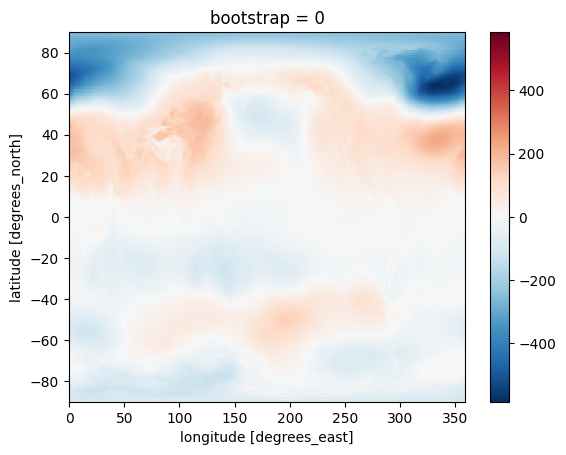

In [36]:
l.isel(bootstrap=0).plot()

In [32]:
l['bootstrap']

<xarray.DataArray 'bootstrap' (bootstrap: 6)> Size: 48B
array([0, 1, 2, 3, 4, 5])
Coordinates:
  * bootstrap  (bootstrap) int64 48B 0 1 2 3 4 5

In [17]:
from teleconnections import build_confidence_mask

In [18]:
mask = build_confidence_mask(map, l, u, mask_concordance=False)

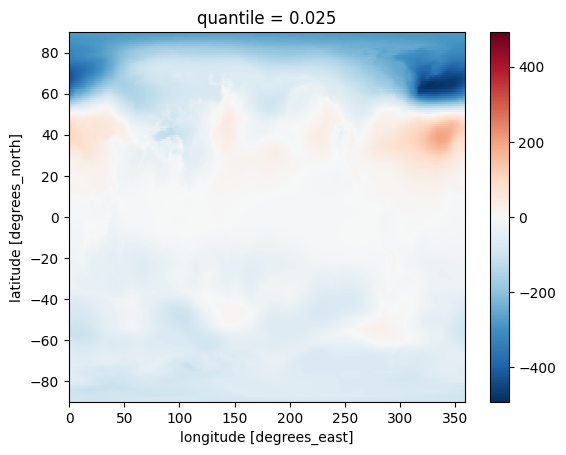

In [19]:
u.plot()

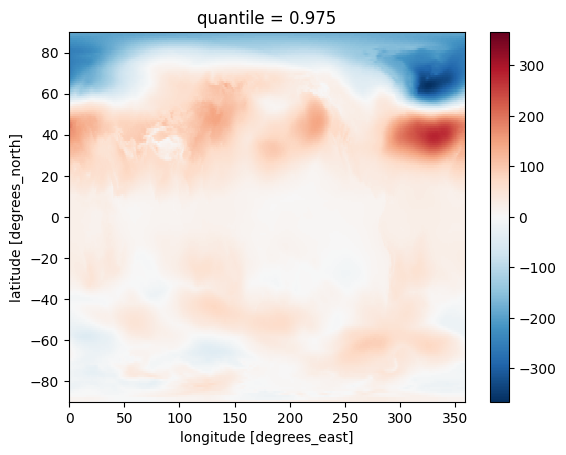

In [20]:
l.plot()

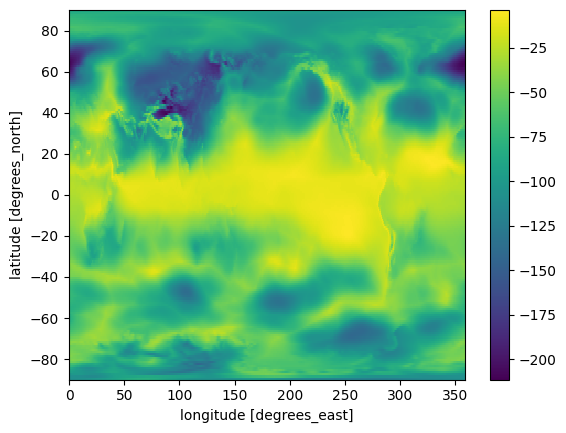

In [21]:
(u-l).plot()

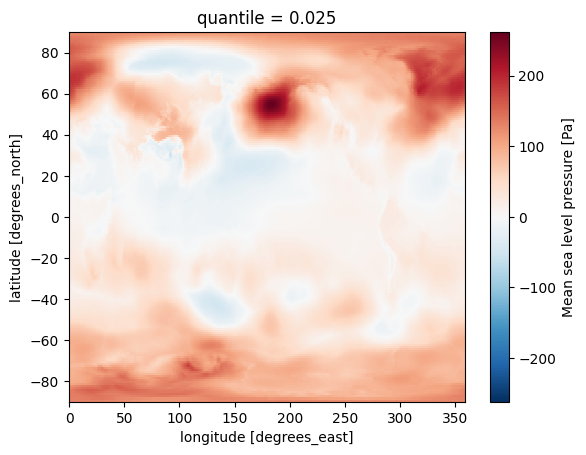

In [26]:
(map-u).plot()

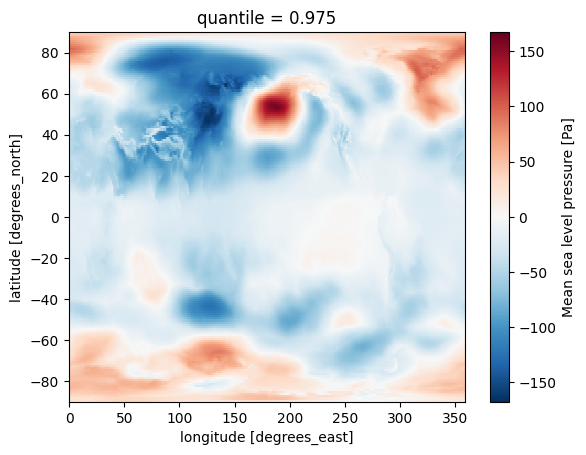

In [27]:
(map-l).plot()

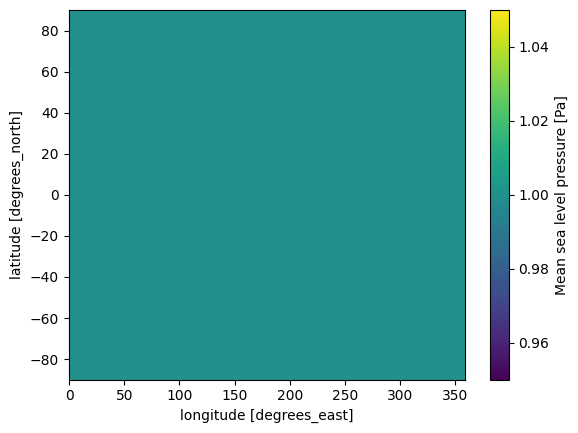

In [23]:
mask.plot()

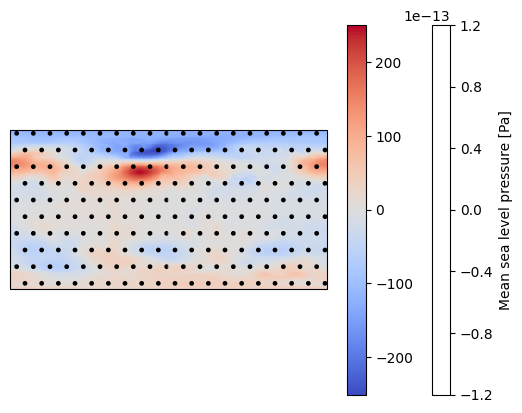

In [26]:
# Plot reg map and mask as stippling
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

reg_plot = map.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False)
mask.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), hatches=['.', None], alpha=0)

fig.colorbar(reg_plot, ax=ax, orientation='vertical')

plt.show()

In [78]:
concordance_results /= num_bootstrap

In [75]:
# Define a new xarray with the concordance results
concordance_map = reg_test.copy(data=concordance_results)

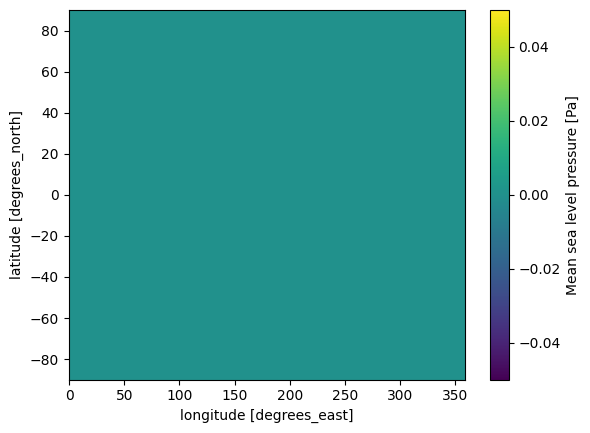

In [76]:
concordance_map.plot()